In [1]:
#Import necessary packages.

from keras.initializers import he_uniform
from keras.layers import Dense
from keras.models import load_model, Sequential
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import pickle

%matplotlib inline

/home/andrzej/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Load functional signatures of premises.

X = np.load('Fun.npy')

(num_contexts, num_fun) = X.shape
print(X.shape)

(102442, 13217)


In [3]:
#Form context distributions for each functor symbol.

output_data = np.zeros((num_fun, num_fun), dtype = 'float32')

for n in range(num_fun):
    for m in range(num_contexts):
        if X[m, n] != 0:
            output_data[n] += X[m]
    output_data[n] /= np.sum(output_data[n])
    
np.save('Output_data', output_data)

In [4]:
#Define input and output data.

input_data = np.identity(num_fun)
output_data = np.load('Output_data.npy')

In [5]:
#Train the embedding model.

model = Sequential()
model.add(Dense(256, kernel_initializer = he_uniform(), activation = 'tanh', input_shape = (num_fun,)))
model.add(Dense(num_fun, kernel_initializer = he_uniform(), activation = 'softmax'))
model.compile(optimizer = RMSprop(decay = 1e-8), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

history = model.fit(np.identity(num_fun), output_data, epochs = 150, batch_size = 2048, shuffle = True, verbose = 0)

model.save('embedding_model.h5')
        
with open('embedding_model_history.pickle', 'wb') as dictionary:
    pickle.dump(history.history, dictionary, protocol=pickle.HIGHEST_PROTOCOL)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               3383808   
_________________________________________________________________
dense_2 (Dense)              (None, 13217)             3396769   
Total params: 6,780,577
Trainable params: 6,780,577
Non-trainable params: 0
_________________________________________________________________


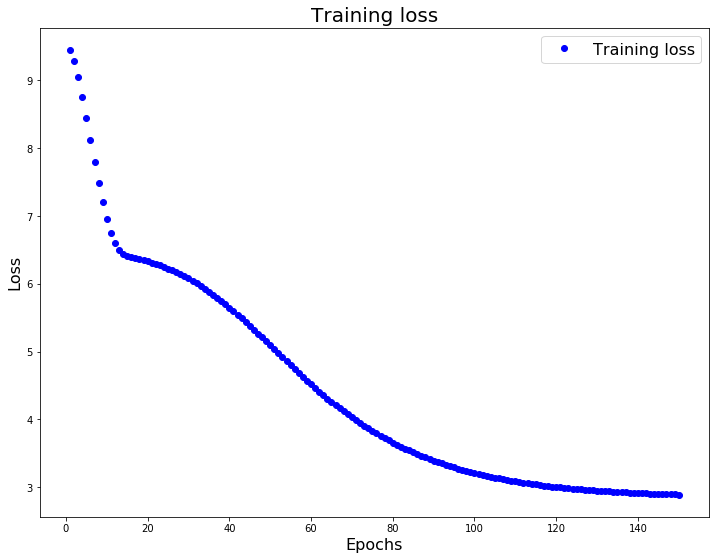

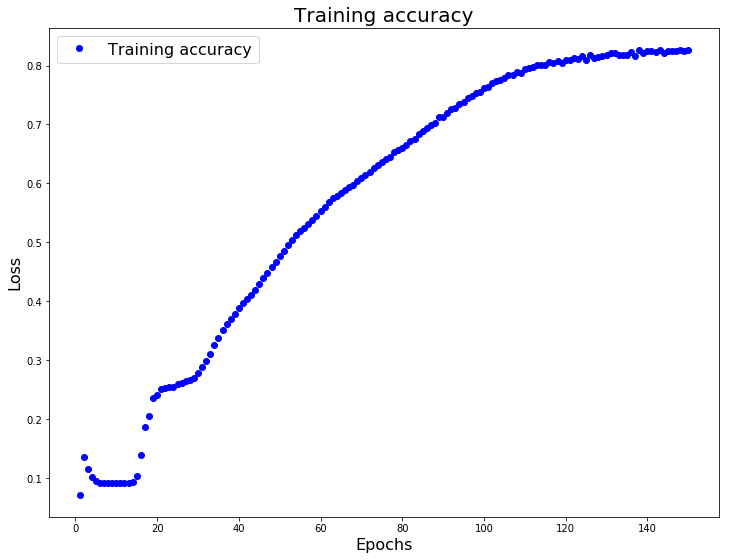

In [6]:
with open('embedding_model_history.pickle', 'rb') as dictionary:
            history_dict = pickle.load(dictionary)

history_dict = history.history
loss_values = history_dict['loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

fig = plt.figure(figsize = (12,9))
plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.title('Training loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig('Training_loss_for_embedding_model.pdf')
plt.show()

fig = plt.figure(figsize = (12,9))
plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.title('Training accuracy', fontsize = 20)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig('Training_accuracy_for_embedding_model.pdf')
plt.show()

In [7]:
#Test context distribution network.

model = load_model('embedding_model.h5')

test_loss, test_acc = model.evaluate(np.identity(num_fun), output_data, verbose = 0)
print('Test loss:', str(round(test_loss, 4)) + '.')
print('Test accuracy:', str(round(100*test_acc, 2)) + '%.')

Test loss: 2.8874.
Test accuracy: 83.17%.


In [8]:
#Save embedded functional signatures.

model = load_model('embedding_model.h5')

weights = model.layers[0].get_weights()
X = np.tanh(np.dot(X, weights[0]) + weights[1])
print(X.shape)

np.save('Conj_tokens', X[:32524])
np.save('Ax_tokens', X[32524:])

(102442, 256)
